<h2>Setup</h2>

In [128]:
import seaborn as sns
from rfpimp import *
import numpy as np
import scipy
from rfpimp import plot_corr_heatmap
import pandas as pd
import PipelineProfiler
import autosklearn.regression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,RANSACRegressor, ARDRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor,MLPClassifier
# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt # for data visualization
from pandas.io.json import json_normalize
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
warnings.filterwarnings("ignore")

<h2>Data</h2>

In [38]:
## KenPom (http://www.kenpom.com)

df = pd.read_csv("cbb_2022_model_train.csv")

<h2>Distribution</h2>

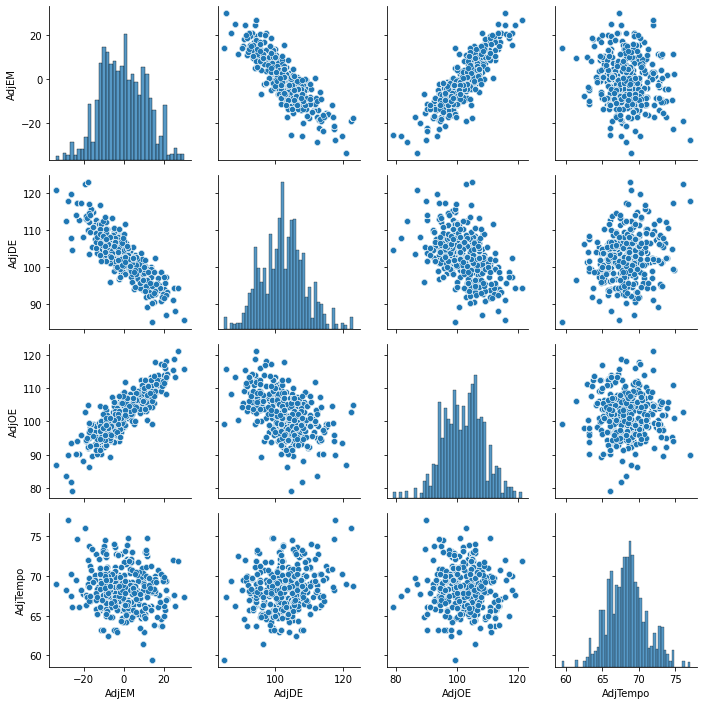

In [34]:

## Distribution of standard and KenPom stats, denoted by "BASE_FEATURES"

BASE_FEATURES = ['AdjEM','AdjDE','AdjOE','AdjTempo']

g = sns.PairGrid(df[BASE_FEATURES])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

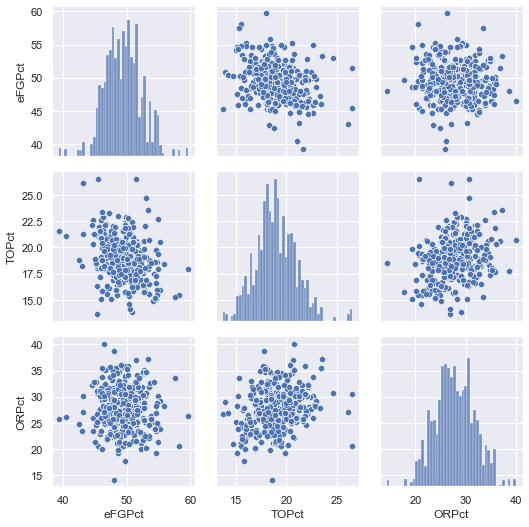

In [89]:
## Distribution of decomposed stats

BASE_FEATURES = ['AdjEM','AdjDE','AdjOE','AdjTempo']
DECOMPOSED_O_FEATURES = ['eFGPct','TOPct','ORPct']
DECOMPOSED_D_FEATURES = ['eFGPct_d','TOPct_d','ORPct_d']
OTHER = ['Size','Bench','Exp']
ALL_FEATURES = BASE_FEATURES + DECOMPOSED_O_FEATURES + DECOMPOSED_D_FEATURES + OTHER

g = sns.PairGrid(df[DECOMPOSED_O_FEATURES])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

##OFFENSE##

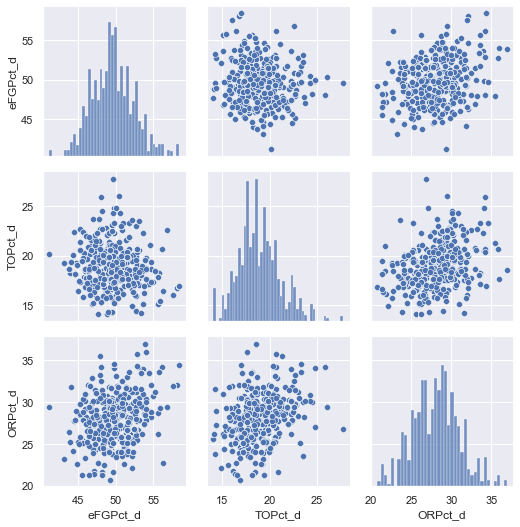

In [130]:
g = sns.PairGrid(df[DECOMPOSED_D_FEATURES])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

##DEFENSE##

<h2>Correlations</h2>

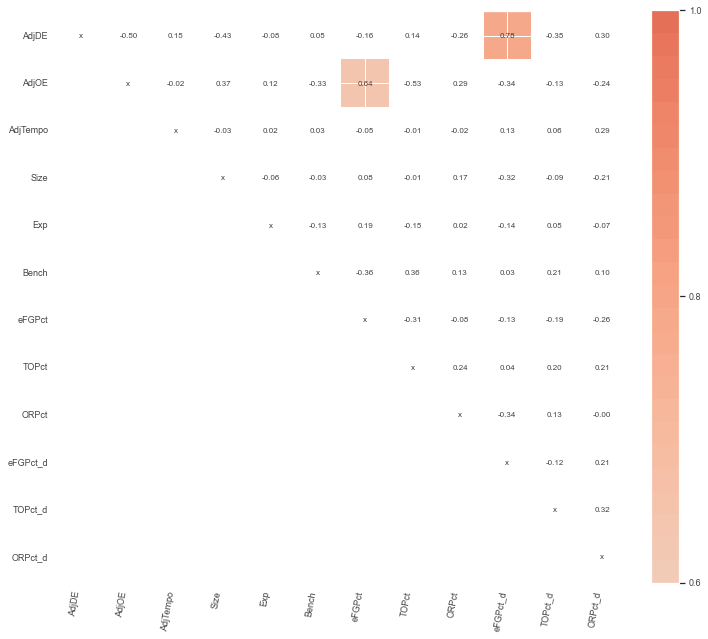

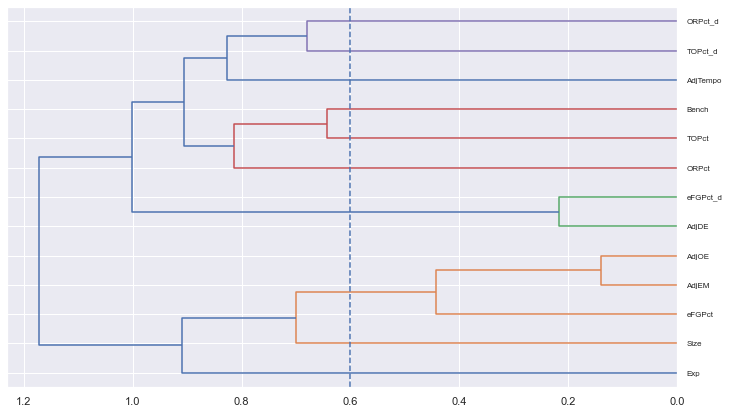

In [116]:
## PLOT A: Correlation Heatmap ####

## Choosing Spearman's coefficient because
    ## a) It's better for identifying continuous, monotonic relationships, as we expect between these features
    ## b) Doesn't assume linearity
    
viz = plot_corr_heatmap(pd.read_csv("cbb_2022_model_train.csv")
                        [BASE_FEATURES + DECOMPOSED_O_FEATURES + DECOMPOSED_D_FEATURES], figsize=(10,10))
viz.view()

## PLOT B: Hierachical analysis ##

X = pd.read_csv("cbb_2022_model_train.csv")[ALL_FEATURES]

# Arbitrary threshold
thresh=0.4
corr = np.round(scipy.stats.spearmanr(X).correlation, 4)

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
_= plt.figure(figsize=(12,7))
dendrogram = hc.dendrogram(z,labels=X.columns, orientation='left', leaf_font_size=8)
plt.axvline(1-thresh,linestyle='--')
plt.show()

<h2>Dependencies</h2>

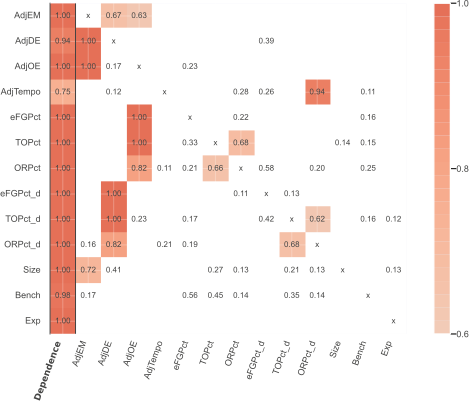

In [100]:

## Based on above, we can already comfortably remove some of the tightly correlated variables (eg. remove eFGPct_o in lieu of AdjOE )
## Now looking at the dependency matrix below, it not only proves the redundant correlations, but gives some insight into how KenPom constructs his high-level statistics.  We can remove some more input variables based on this

dependence_matrix = feature_dependence_matrix(pd.read_csv("cbb_2022_model_train.csv")[ALL_FEATURES],
                          rfrmodel=RandomForestRegressor(n_estimators=20, oob_score=True),
                         # rfcmodel=RandomForestClassifier(n_estimators=10, oob_score=True),
                          cat_count=200,
                          zero=0.1,
                          sort_by_dependence=False,
                          n_samples=5000)

plot_dependence_heatmap(dependence_matrix, figsize=(10,6))

## Note: Below builds ad-hoc models, treating each of the potential features as dependent variables, and measuring the R^2 of the remaining variables

## Simplified, the x-axis variables can be "explained" by the y-axis variables by the score denoted in D(x,y)


<h2>Feature Selection</h2>

In [ ]:
# Final set of input variables:

# 'AdjDE','AdjOE','AdjTempo','Size','Exp','Bench'
# Tempo Total
#  Em Total

<h2>Model Selection</h2>

Train size: 6278
Test size: 173
LinearReg
MAE:  8.386
ERR vs Vegas:  -10.264
RF
MAE:  9.841
ERR vs Vegas:  -8.81
KNN
MAE:  9.201
ERR vs Vegas:  -9.449
ExtraTreesRegressor
MAE:  8.815
ERR vs Vegas:  -9.836
AdaBoostRegressor
MAE:  9.023
ERR vs Vegas:  -9.627
GradientBoostingRegressor
MAE:  8.584
ERR vs Vegas:  -10.066
ARDRegression
MAE:  8.374
ERR vs Vegas:  -10.276
MLPRegressor
MAE:  8.406
ERR vs Vegas:  -10.244
                           fit_time  score_time  test_r2  \
model                                                      
ARDRegression                 0.009       0.004    0.516   
AdaBoostRegressor             0.464       0.014    0.432   
ExtraTreesRegressor           1.622       0.044    0.414   
GradientBoostingRegressor     0.990       0.006    0.490   
KNN                           0.006       0.088    0.408   
LinearReg                     0.008       0.006    0.515   
MLPRegressor                  0.962       0.005    0.510   
RF                            1.124       0.0

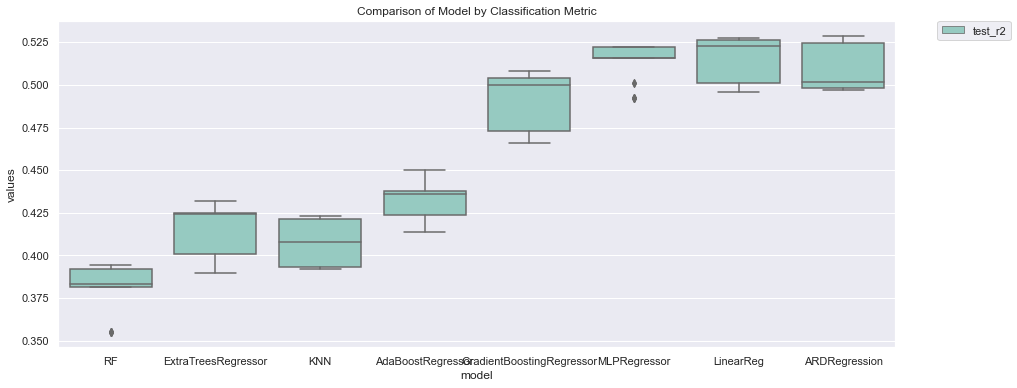

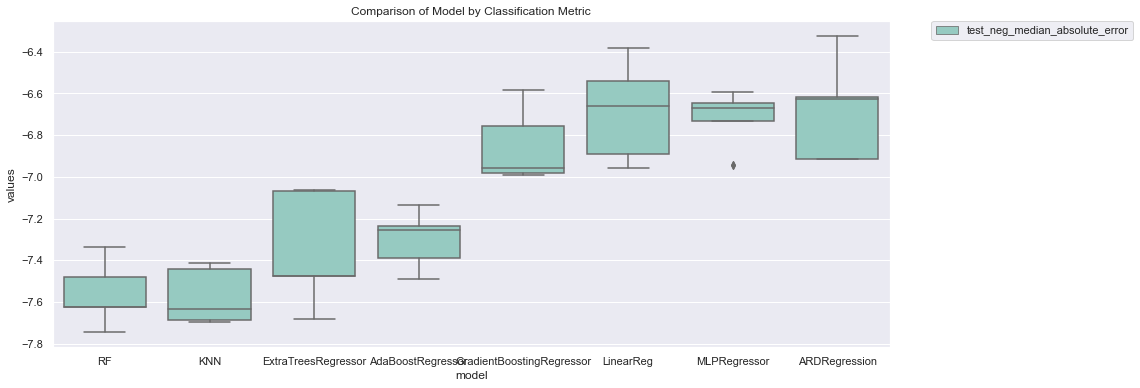

In [133]:

# Evaluates various models benchmarked against
    ## Mean Absolute Error against real score
    ## Error against opening Vegas spread
    

## Features
BASE_FEATURES = ['AdjDE','AdjOE','AdjTempo',
                 'Size','Exp','Bench']
FEATURES = []
for f in BASE_FEATURES:
    FEATURES = FEATURES + [f] + [f+"_opp"]
FEATURES = FEATURES + ["home"] + ["tempoTotal","emTotal"]

bcf = df
bcf['tempoTotal']=bcf.AdjTempo + bcf.AdjTempo_opp
bcf['emTotal']=bcf.AdjEM + bcf.AdjEM_opp

TARGET = ['margin']



#########################

#######
########################################################
# PCA transformations (dimensionality reduction)
## NOT BEING USED, but could be useful

PCA_TRANSFORMATIONS=2

bcf['abs_vegas_error']=abs(bcf.margin-bcf.spread)
bcf = bcf.dropna(subset=FEATURES)


scaler = StandardScaler()
Xt = bcf.query(TRAIN_QUERY)[FEATURES]
Xt = scaler.fit_transform(Xt)
pca = PCA(n_components=PCA_TRANSFORMATIONS)
pca.fit(Xt)
X = bcf[FEATURES]
X = scaler.fit_transform(X)
X_pca = pca.transform(X)
#X = scaler.fit_transform(X)

#FEATURES=[]


for i in range(0,PCA_TRANSFORMATIONS):
    bcf['PCA'+str(i)] = X_pca[:,i]
    #FEATURES = FEATURES + ['PCA'+str(i)]


#######

#######
########################################################
#Normalize the data, split data set into train / test

#bcf = bcf[FEATURES+TARGET+['spread']].dropna()

#ARBITRATY SPLIT BETWEEN TRAIN AND TEST ###
TRAIN_QUERY="conference!='MWC'"
TEST_QUERY="conference=='MWC'"

X_train = bcf.query(TRAIN_QUERY)[FEATURES+TARGET+['abs_vegas_error','spread']].dropna()
y_train = bcf.query(TRAIN_QUERY)[TARGET].dropna()
print("Train size: " + str(len(y_train)))


X_test = bcf.query(TEST_QUERY)[FEATURES+TARGET+['abs_vegas_error','spread']].dropna()
y_test = bcf.query(TEST_QUERY)[TARGET].dropna()
print("Test size: " + str(len(X_test)))


########################################################
# Evaluate models
dfs = []
models = [
          ('LinearReg', LinearRegression()), 
          ('RF', RandomForestRegressor(max_depth=4,max_leaf_nodes=40)),
          ('KNN', KNeighborsRegressor(n_neighbors=50,weights='distance')),
          #('SVM', SVC()), 
          #('GNB', GaussianNB()),
          #('DecisionTreeRegressor', DecisionTreeRegressor()),
          ('ExtraTreesRegressor', ExtraTreesRegressor()),
          ('AdaBoostRegressor', AdaBoostRegressor()),
          ('GradientBoostingRegressor', GradientBoostingRegressor()),
          ('ARDRegression', ARDRegression()),
         # ('RANSACRegressor', RANSACRegressor()),
          ('MLPRegressor', MLPRegressor(random_state=1, max_iter=250, hidden_layer_sizes=100)),
    
        ]
results = []
names = []
scoring = ['r2', 'neg_median_absolute_error']

for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)

        cv_results = model_selection.cross_validate(model, X_train[FEATURES].append(X_test[FEATURES]), X_train[TARGET].append(X_test[TARGET]), cv=kfold, scoring=scoring)
        clf = model.fit(X_train[FEATURES], X_train[TARGET])
        X_test['pred'] = clf.predict(X_test[FEATURES])
        print(name)
        print("MAE: " , round(abs(X_test.pred - X_test.margin).mean(),3))
        print("ERR vs Vegas: " , round((abs(X_test.pred - X_test.margin) - X_test.abs_vegas_error).mean(),3))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)


########################################################
# Performance metrics

bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(15, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit.query("metrics =='test_r2'").sort_values(by='values'), palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

plt.figure(figsize=(15, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit.query("metrics =='test_neg_median_absolute_error'").sort_values(by='values'), palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')


print(round(final.groupby("model").mean(),3))



<h2>Parameter Optimization / Final Model</h2>

In [141]:
## Based on above, we choose ARD Regression as our optimal model
## AutoML for parameter optimization ###

import pickle
m = pickle.load(open("model_finalModel_15min_train_20221227", 'rb'))

"""
automl = autosklearn.regression.AutoSklearnRegressor(
      time_left_for_this_task=120,
      per_run_time_limit=30,
      metric=autosklearn.metrics.mean_absolute_error,
      initial_configurations_via_metalearning=0,
      include = {
            'regressor': ["ard_regression"],
            #'feature_preprocessor': ["no_preprocessing"]
      },
      #smac_scenario_args={'runcount_limit': 25},
      n_jobs=8
)

automl.fit(df[FEATURES], df[TARGET], dataset_name='cbb')
"""
profiler_data= PipelineProfiler.import_autosklearn(m)
PipelineProfiler.plot_pipeline_matrix(profiler_data)
print(m.leaderboard())

          rank  ensemble_weight            type       cost   duration
model_id                                                             
41           1             0.46  ard_regression   8.151920   0.950228
16           2             0.30   liblinear_svr   8.154752   0.679343
8            3             0.02  ard_regression   8.157670   0.866639
40           4             0.08   decision_tree   9.070918   1.560736
17           5             0.04   random_forest   9.523576  94.014346
49           6             0.06   decision_tree   9.695408   1.404224
21           7             0.04   decision_tree  10.462245   0.876622
